<a href="https://colab.research.google.com/github/RumeysaCeylan/ImageClassification/blob/main/densenet169_finall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
#IMPORT / VIEWING / PREPROCESSING DATASET

In [ ]:
#DATA AUGMENTATION

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 19175 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 799 images belonging to 4 classes.


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


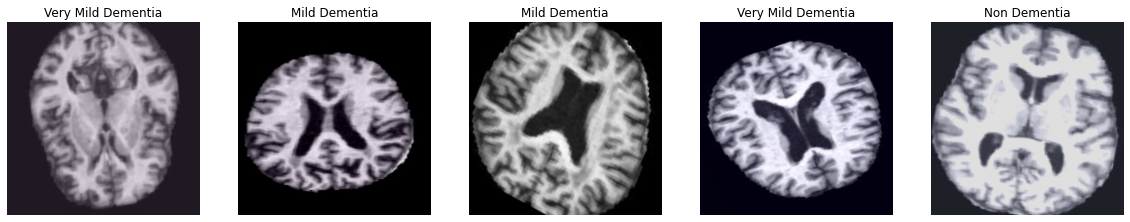

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [ ]:
#MODEL BUILDING

In [49]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 1s 0us/step


In [50]:

# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [51]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [52]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [53]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [54]:
import tensorflow as tf

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [55]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics = METRICS,
              optimizer=OPT)

In [56]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [57]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 1.1374 - accuracy: 0.7831 - precision: 0.5806 - recall: 0.4762 - auc: 0.8087 - f1_score: 0.5230 
Epoch 1: val_auc improved from -inf to 0.90507, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 5783s 39s/step - loss: 1.1374 - accuracy: 0.7831 - precision: 0.5806 - recall: 0.4762 - auc: 0.8087 - f1_score: 0.5230 - val_loss: 0.7575 - val_accuracy: 0.8445 - val_precision: 0.7227 - val_recall: 0.6133 - val_auc: 0.9051 - val_f1_score: 0.6745
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.8244 - precision: 0.6793 - recall: 0.5633 - auc: 0.8799 - f1_score: 0.6158
Epoch 2: val_auc improved from 0.90507 to 0.93293, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 275s 2s/step - loss: 0.8264 - accuracy: 0.8244 - precision: 0.6793 - recall: 0.5633 - auc

In [ ]:
#MODEL EVALUATION

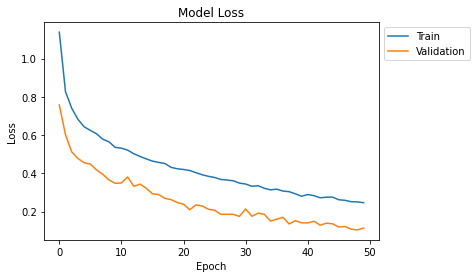

In [58]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

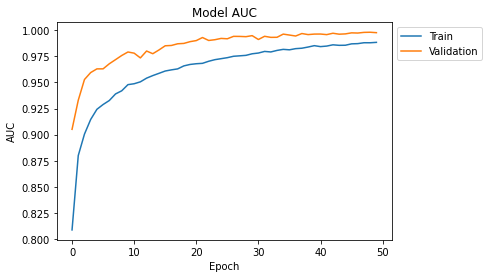

In [59]:
# Summarize history for auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

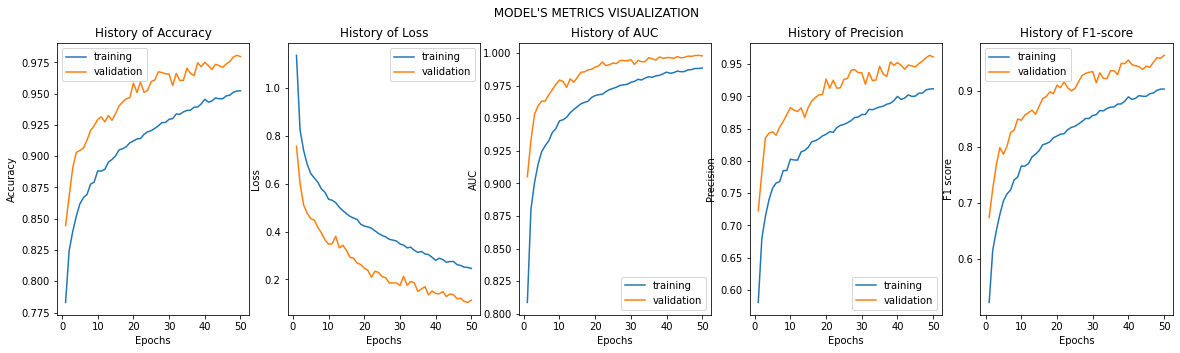

In [60]:

#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],
               model_history.history['f1_score'],model_history.history['val_f1_score']
              )

In [6]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 2000 images belonging to 4 classes.


In [62]:
# Evaluating Loss and AUC

score=model.evaluate(test_dataset)


16/16 [==============================] - 7s 416ms/step - loss: 0.1399 - accuracy: 0.9721 - precision: 0.9467 - recall: 0.9415 - auc: 0.9961 - f1_score: 0.9440


In [63]:
print("Loss = ",score[0])
print("Accuracy = ", score[1])
print("Precision = ", score[2])
print("Recall = ", score[3])
print("AUC = ", score[4])
print("F1_score = ", score[5])

Loss =  0.13992030918598175
Accuracy =  0.9721249938011169
Precision =  0.9467068910598755
Recall =  0.9415000081062317
AUC =  0.9961194396018982
F1_score =  0.9439526796340942


In [64]:
pred = model.predict(test_dataset, batch_size = 8)

16/16 [==============================] - 9s 416ms/step


In [65]:
pred_final = np.where(pred>0.5,1,0)

In [73]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)
testing_generator = testing_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Test',
target_size = (224,224),
batch_size=128,
shuffle=False,
class_mode='categorical')

Found 2000 images belonging to 4 classes.


In [88]:
test_dataset.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
"""
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
def plot_roc_curve(y_pred, pred, normalize=True, title='roc_curve', cmap=plt.cm.Blues):
  fpr, tpr, _ = roc_curve(
                        y_pred,
                        pred
                       )
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
target_names = []


# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('roc_curve')
for i in test_dataset:
  target_names.append(i)
print(i)
"""

<ipython-input-75-f72fa186db01>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testing_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.96      0.98      0.97       500
ModerateDemented       1.00      1.00      1.00       500
     NonDemented       0.89      0.92      0.91       500
VeryMildDemented       0.93      0.88      0.90       500

        accuracy                           0.95      2000
       macro avg       0.95      0.95      0.95      2000
    weighted avg       0.95      0.95      0.95      2000



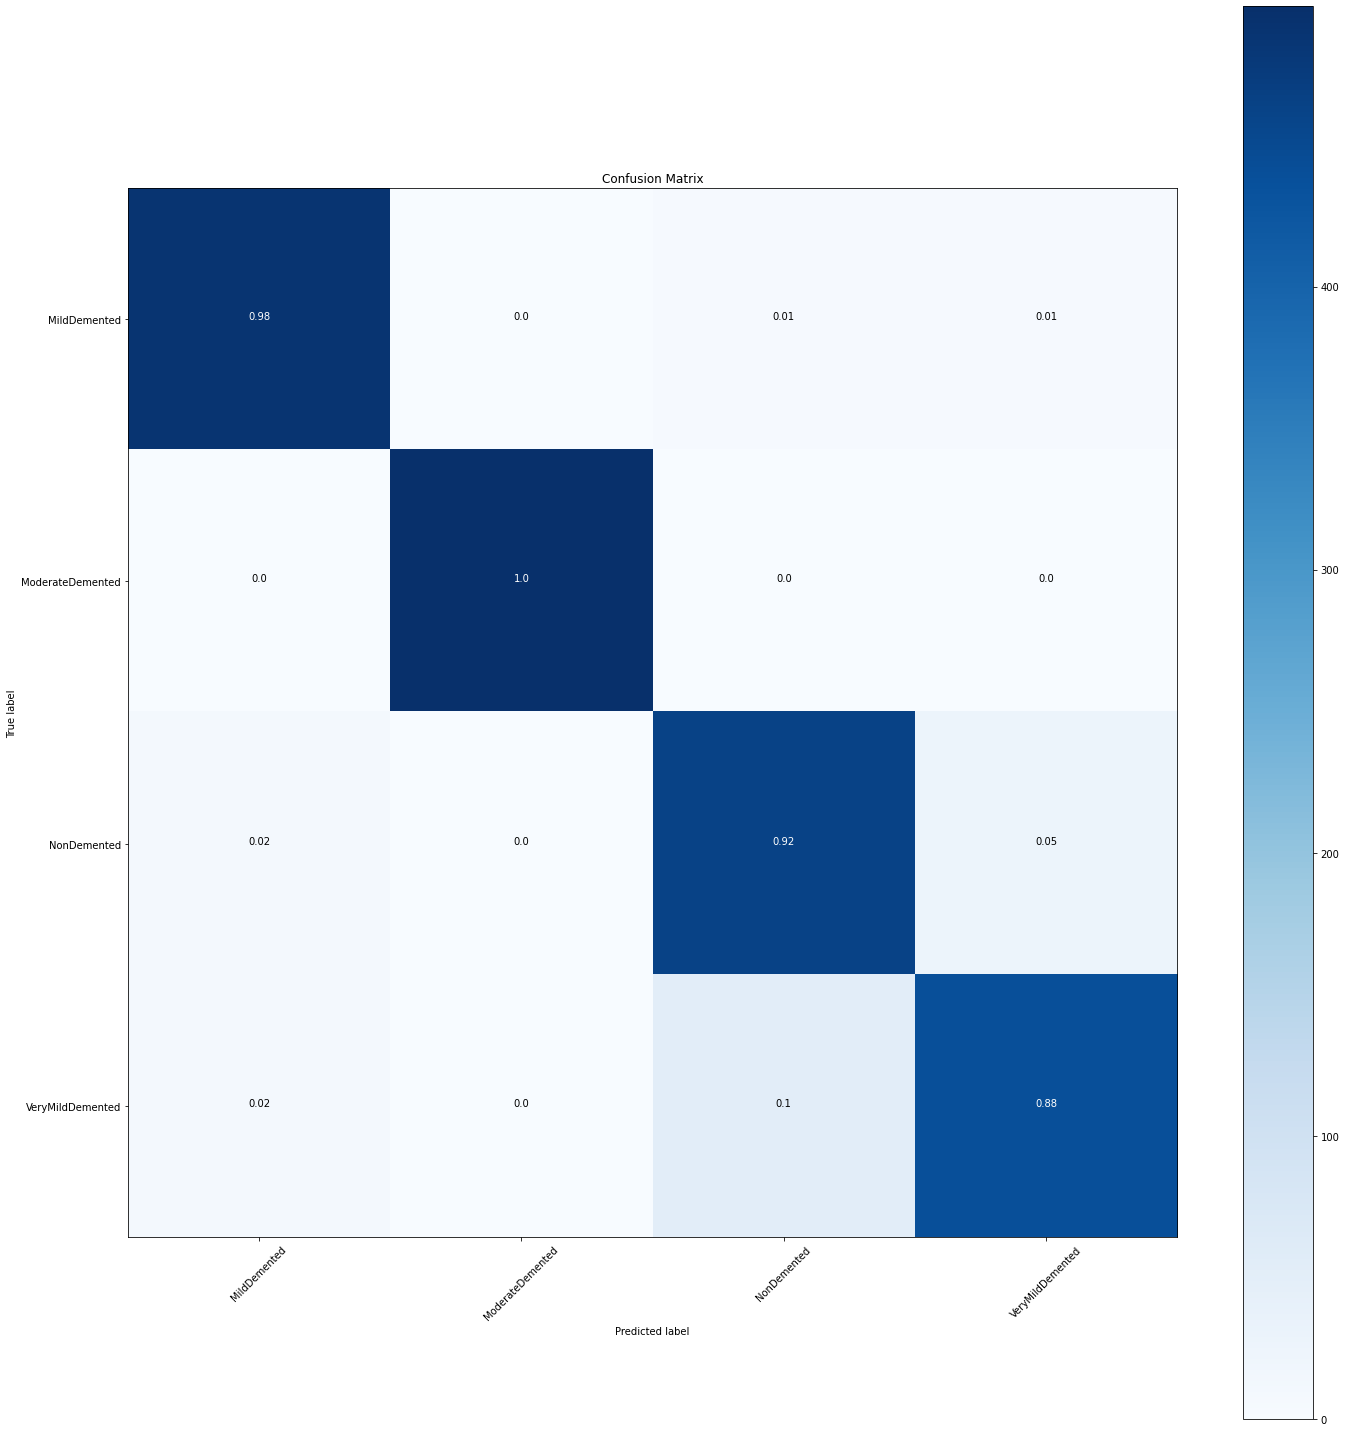

In [75]:
#Plot the confusion matrix. Set Normalize = True/False
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_dataset.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

In [8]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5', compile = False)

1/1 [==============================] - 13s 13s/step
99.9 % chances are there that the image is NonDemented


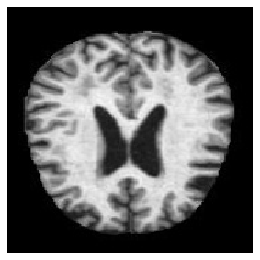

In [9]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00b8529f-23c6-415c-96cc-a4e6ca6ed6ac.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
99.91 % chances are there that the image is NonDemented


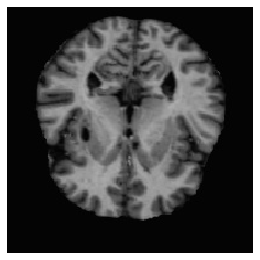

In [ ]:
# Test Case 1_1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00e94d2d-4d78-43eb-933e-1c8cbfe974fd.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 47ms/step
99.96 % chances are there that the image is NonDemented


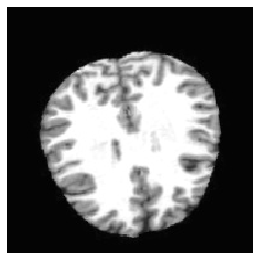

In [ ]:
# Test Case 1_2: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/01a1f60e-a95b-4f6b-b84a-d35c5b241bb1.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 46ms/step
99.39 % chances are there that the image is NonDemented


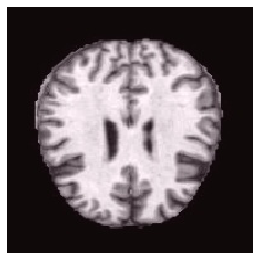

In [ ]:
# Test Case 1_3: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0ab1d152-a70b-451a-9840-da1bb72e6b91.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 51ms/step
99.84 % chances are there that the image is NonDemented


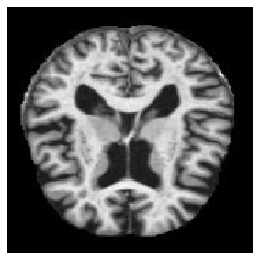

In [ ]:
# Test Case 1_4: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0b7e0c7c-eee7-49de-931c-cffaa8d1bbcc.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 41ms/step
99.98 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 35ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 31ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 104ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
100.0 % chances are there that the image is

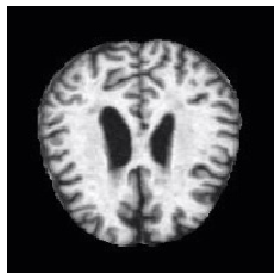

In [ ]:


import cv2
import glob 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [14]:
# MODERATE 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))
mod_percent=100*correct_num/img_num

1/1 [==============================] - 0s 30ms/step
correct: 500
images: 500
percentage: 1.0


1/1 [==============================] - 0s 48ms/step
99.92 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 32ms/step
97.81 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.52 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 31ms/step
99.98 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.67 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 83ms/step
99.98 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 33ms/step
99.9 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 39ms/step
100.0 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.9 % chances are there that the image is MildDemented
1/1 [================

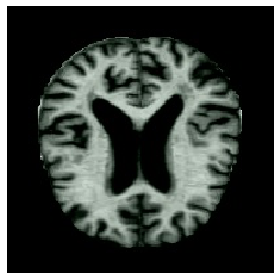

In [ ]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [13]:
# MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))
mild_percent=100*correct_num/img_num

1/1 [==============================] - 0s 29ms/step
correct: 489
images: 500
percentage: 0.978


In [12]:
# NON

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/NonDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))
non_percent=100*correct_num/img_num

1/1 [==============================] - 0s 34ms/step
correct: 468
images: 500
percentage: 0.936


In [11]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))
mild_percent=100*correct_num/img_num

1/1 [==============================] - 0s 30ms/step
correct: 489
images: 500
percentage: 0.978


In [10]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/VeryMildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))
very_percent=100*correct_num/img_num

1/1 [==============================] - 0s 34ms/step
correct: 439
images: 500
percentage: 0.878


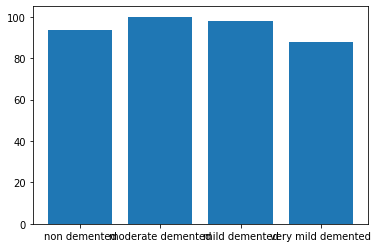

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["non demented", "moderate demented", "mild demented", "very mild demented"])
y = np.array([non_percent, mod_percent, mild_percent, very_percent])

plt.bar(x,y)
plt.show()